In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


In [3]:
restaurants = gpd.read_file("data/restaurants_clustered.geojson")
waste = pd.read_csv("data/pune_waste_cleaned.csv")


In [15]:
restaurants["rating"] = (
    restaurants["rating"]
    .astype(str)
    .str.replace("NEW", "", regex=False)
    .str.replace("Not rated", "", regex=False)
    .str.replace("-", "", regex=False)
    .str.strip()
    .replace("", np.nan)
    .astype(float)
)


In [16]:
restaurants["rating"].unique()[:20]


array([2.5, 3.8, 3.3, 3.5, 4.4, 4. , 3.7, 2.8, 3.1, 3.2, 3.9, 3.6, 2.3,
       4.5, 4.2, nan, 4.8, 4.1, 2.6, 0. ])

In [17]:
restaurants["surplus_score"] = (
    0.4 * restaurants["avg_cost"].fillna(0) +
    0.3 * (5 - restaurants["rating"].fillna(0)) +
    0.3 * restaurants["waste_density"].fillna(0)
)


In [18]:
restaurants["surplus_score"] = (
    restaurants["surplus_score"] - restaurants["surplus_score"].min()
) / (
    restaurants["surplus_score"].max() - restaurants["surplus_score"].min()
)


In [19]:
features = restaurants[[
    "avg_cost",
    "rating",
    "ward_count",
    "waste_density"
]].fillna(0)

target = restaurants["surplus_score"]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)


In [23]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

model.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
preds = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, preds))
print("R2:", r2_score(y_test, preds))


MAE: 0.0016070385330083385
R2: 0.9985990697750728


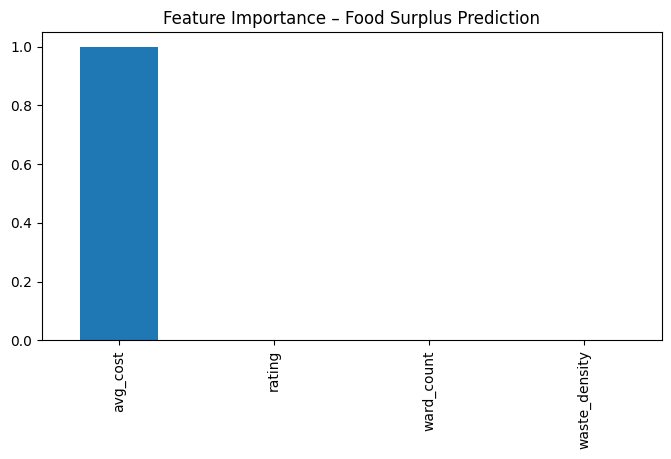

In [27]:
importances = pd.Series(
    model.feature_importances_,
    index=features.columns
).sort_values(ascending=False)

importances.plot(kind="bar", figsize=(8,4))
plt.title("Feature Importance – Food Surplus Prediction")
plt.show()


In [28]:
restaurants["predicted_surplus"] = model.predict(features)


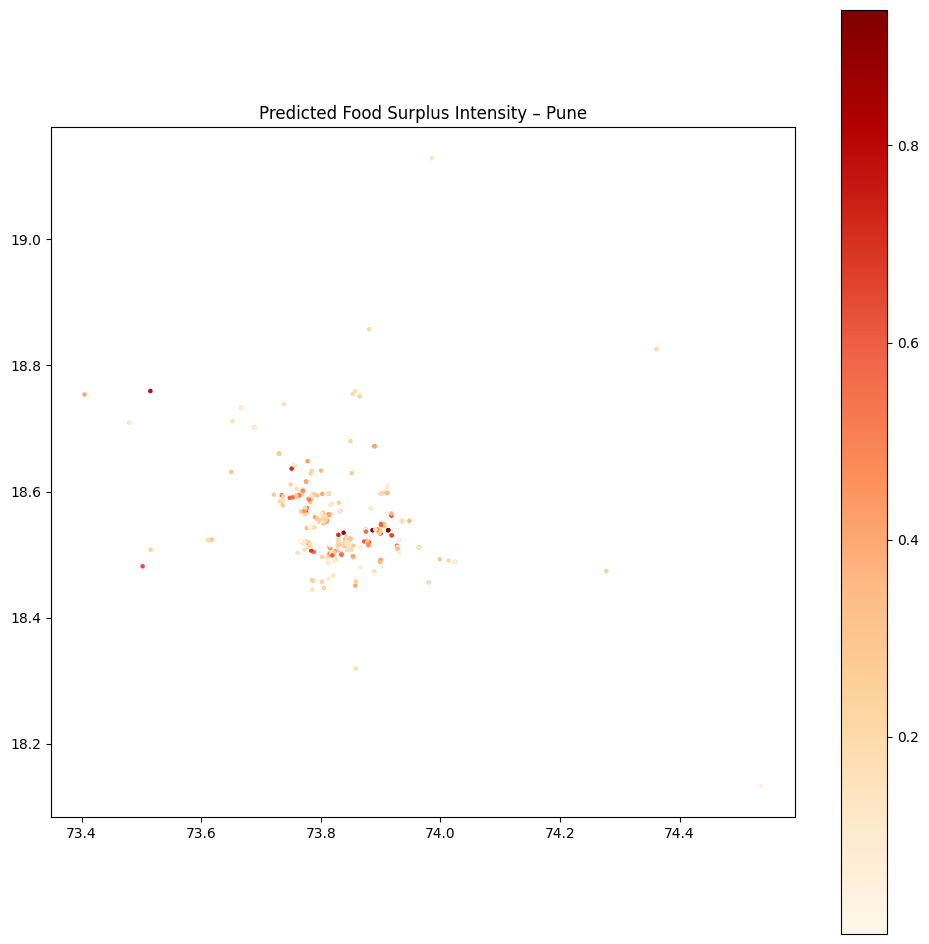

In [30]:
restaurants.plot(
    column="predicted_surplus",
    cmap="OrRd",
    legend=True,
    figsize=(12,12),
    markersize=5
)
plt.title("Predicted Food Surplus Intensity – Pune")
plt.show()


In [31]:
restaurants.to_file(
    "restaurants_with_surplus.geojson",
    driver="GeoJSON"
)
